In [37]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf
xr.set_options(keep_attrs=True)

In [38]:
mydir = '/glade/work/lettier/NUDGE/processed/timeseries/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir)) if 'trefht_timeseries' in f]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))

In [39]:
listds = []
for f in myfiles: 
        ds = xr.open_dataset(f).sel(region='60-90N')
        listds.append(ds)
ds = xr.concat(listds,dim='names')

In [40]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')

In [41]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_archi','anom_nudge_era_60_arclo']
a60nudgemean = ds.isel(names=0).copy()
for var in ds:
    a60nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [42]:
thenudge = ['anom_nudge_era','anom_nudge_era_low','anom_nudge_era_high']
anudgemean = ds.isel(names=0).copy()
for var in ds:
    anudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
anudgemean['names'] = 'aNUDGE45mean'
anudgemean = anudgemean.set_coords('names')

In [43]:
ds = xr.concat([ds,lensmean, a60nudgemean, anudgemean],dim='names')

In [44]:
mylist = []
for f in ds.names.values:
    if 'LENSmean' in f:
        mylist.append({'label' : 'LENSmean', 'c' : 'tab:blue', 'linewidth' : 1.5, 'alpha' : 1.})
 
    elif 'LENS' in f:
        mylist.append({'label' : 'LENS', 'c' : 'tab:blue', 'linewidth' : .5, 'alpha' : .3})
        
    elif '60' in f:
        mylist.append({'label' : 'aNUDGE', 'c' : 'tab:red', 'linewidth' : 1.5, 'alpha' : 1.})
      
    elif 'anom' in f:
        mylist.append({'label' : 'aNUDGE45', 'c' : 'orange', 'linewidth' : 1.5, 'alpha' : 1.})
        
    elif 'ERA' in f or 'GIS'  in f or 'HadC' in f:
         mylist.append({'label' : 'OBS-'+f, 'c' : 'k', 'linewidth' : 1.5, 'alpha' : 1.})
    else:
        print(f)
        mylist.append({'label' : 'NUDGE', 'c' : 'tab:red', 'linewidth' : 1.5, 'alpha' : 1.})
  
df = pd.DataFrame(mylist, index = ds.names.values) 
df = df.transpose()

nudge_era_NH
nudge_era_SH
nudge_era_high
nudge_era_low
qing_era_6
aNUDGEmean
aNUDGE45mean


In [45]:

da = myf.xr_reshape(ds.TREFHT,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])
slope, intercept, r_value, p_value, std_err = myf.linregress(da.year, da.load(), dim='year')

annmean = mydata = ds.groupby('time.year').mean(dim='time').TREFHT
annmean_slope, _, _, _, _ = myf.linregress(da.year, annmean.load(), dim='year')

detrended = da - slope*da.year
detrendedannmean = annmean - annmean_slope*annmean.year

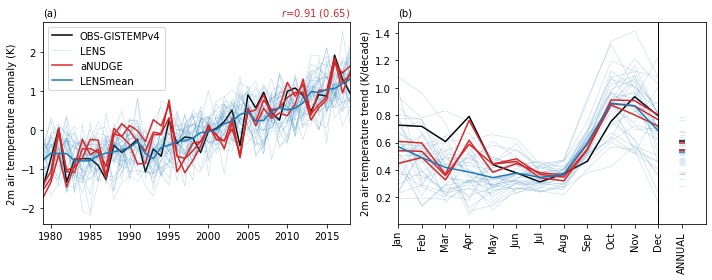

In [46]:

fig = plt.figure(figsize=(10,4))


ax = plt.subplot(1,2,1)
for n, name in enumerate(ds.names.values):
    if 'GIS' in name or '60' in name or 'LENS' in name:
        mydata = ds.sel(names=name).groupby('time.year').mean(dim='time').TREFHT
        anom = mydata - mydata.mean(dim='year')
        anom.plot(ax = ax, **df[name].to_dict())

        
pearson3, _ = myf.pearson(ds.groupby('time.year').mean(dim='time').TREFHT.sel(names='GISTEMPv4').load(), ds.groupby('time.year').mean(dim='time').TREFHT.sel(names='aNUDGEmean').load(),dim='year')
pearson3detrended, _ = myf.pearson(detrendedannmean.sel(names='GISTEMPv4').load(), detrendedannmean.sel(names='aNUDGEmean').load(),dim='year')

ax.set_title('')
ax.set_title('(a)',fontsize=10,loc='left')
ax.set_title('$r$={:0.2f} ({:1.2f})'.format(pearson3.values,pearson3detrended.values), fontsize=10, loc='right',c='tab:red')
ax.set_xlim([1979,2018])
ax.set_ylabel('2m air temperature anomaly (K)')
ax.set_xlabel('')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc=('upper left'))


ax = plt.subplot(1,2,2)
for n, name in enumerate(ds.names.values):
    if 'GIS' in name or '60' in name or 'LENS' in name:
        (10.*slope).isel(names=n).plot(ax = ax, **df[name].to_dict())     
        ax.scatter(13,10.*annmean_slope.sel(names=name),**df[name].to_dict(), marker='_')
ax.set_title('')
ax.set_title('(b)', fontsize=10, loc='left')
ax.set_xlim([1,14])
ax.set_xticks(np.arange(1,14,1))
ax.set_xticklabels(myf.monthnames+['ANNUAL'], rotation='vertical')
ax.set_xlabel('')
ax.set_ylabel('2m air temperature trend (K/decade)')
ax.axvline(x=12,c='k',linewidth=1)


plt.tight_layout()
fig.savefig('figs/tas.pdf', dpi=500, bbox_inches='tight')
plt.show(); plt.close()

In [47]:
ds  = ds.groupby('time.year').mean(dim='time')

In [48]:
ds

<xarray.Dataset>
Dimensions:      (names: 52, year: 40)
Coordinates:
    realization  int64 100
  * names        (names) <U23 'ERAI' 'GISTEMPv4' ... 'aNUDGEmean' 'aNUDGE45mean'
    region       <U6 '60-90N'
  * year         (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018
Data variables:
    TREFHT       (year, names) float64 263.5 -0.4629 -0.598 ... 263.5 263.5
Attributes:
    desc:     processed by Lettie Roach, March 2021

In [49]:

trend_1979to2018, intercept, r_value, p_value_1979to2018, std_err = myf.linregress(ds.year, ds.load(), dim='year')
trend_1979to1998, intercept, r_value, p_value_1979to1998, std_err = myf.linregress(ds.year.isel(year=slice(0,20)), ds.isel(year=slice(0,20)), dim='year')
trend_1999to2018, intercept, r_value, p_value_1999to2018, std_err = myf.linregress(ds.year.isel(year=slice(20,None)), ds.isel(year=slice(20,None)), dim='year')


In [60]:
print('1979-2018: {:.2f} K/decade, p={:3f}'.format(10.*trend_1979to2018[var].sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values,
                                                100.*p_value_1979to2018[var].sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values))

print('1979-1998: {:.2f} K/decade, p={:3f}'.format(10.*trend_1979to1998[var].sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values,
                                                100.*p_value_1979to1998[var].sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values))

print('1999-2018: {:.2f} K/decade, p={:3f}'.format(10.*trend_1999to2018[var].sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values,
                                                100.*p_value_1999to2018[var].sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values))

1979-2018: 0.56 K/decade, p=0.000000
1979-1998: 0.43 K/decade, p=8.469043
1999-2018: 0.93 K/decade, p=0.000451


In [59]:
print('1979-2018: {:.2f} K/decade, p={:3f}'.format(10.*trend_1979to2018[var].sel(names='ERAI').values,
                                                100.*p_value_1979to2018[var].sel(names='ERAI').values))

print('1979-1998: {:.2f} K/decade, p={:3f}'.format(10.*trend_1979to1998[var].sel(names='ERAI').values,
                                                100.*p_value_1979to1998[var].sel(names='ERAI').values))

print('1999-2018: {:.2f} K/decade, p={:3f}'.format(10.*trend_1999to2018[var].sel(names='ERAI').values,
                                                100.*p_value_1999to2018[var].sel(names='ERAI').values))

1979-2018: 0.66 K/decade, p=0.000000
1979-1998: 0.35 K/decade, p=5.206635
1999-2018: 0.89 K/decade, p=0.004771


In [51]:
ds.names.values

array(['ERAI', 'GISTEMPv4', 'HadCRUT5', 'LENS01', 'LENS02', 'LENS03',
       'LENS04', 'LENS05', 'LENS06', 'LENS07', 'LENS08', 'LENS09',
       'LENS10', 'LENS11', 'LENS12', 'LENS13', 'LENS14', 'LENS15',
       'LENS16', 'LENS17', 'LENS18', 'LENS19', 'LENS20', 'LENS21',
       'LENS22', 'LENS23', 'LENS24', 'LENS25', 'LENS26', 'LENS27',
       'LENS28', 'LENS29', 'LENS30', 'LENS31', 'LENS32', 'LENS33',
       'LENS34', 'LENS35', 'anom_nudge_era', 'anom_nudge_era_60',
       'anom_nudge_era_60_archi', 'anom_nudge_era_60_arclo',
       'anom_nudge_era_high', 'anom_nudge_era_low', 'nudge_era_NH',
       'nudge_era_SH', 'nudge_era_high', 'nudge_era_low', 'qing_era_6',
       'LENSmean', 'aNUDGEmean', 'aNUDGE45mean'], dtype='<U23')